In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-prediction-on-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F53569%2F5834979%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240221%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240221T115847Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D832af002a3ac43dbd32f8e58333a6c041d27496dd6158a3a1c824bec2946d9010ec7433a9d0c788517cfae2fead809f5b85e36c17db4a824d8ba1475f75bf0350b62762e626ee41a274fd4770138d07a06f22270a257c9a5aa187904134ec726b50a19395c84db71a5ce85ce106c8c9efec692d33a4e635fa34a408a77e5e59d157c4520b538e49091cbc29c94a3b2abc914156437735c47928d475b0dec4088f7a5fcc95cdc8108abcff5d00a036f646a47088be11eefadd3ed2f4df842cc89477b2d549457840f191bca47789935722dcba97493730fc66cd11d6675f695242caf4f172ff10dcb19727fbe602a442b2930c6fa545685efc2c60267b0757359'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21802216 bytes downloaded
Downloaded and uncompressed: sentiment-prediction-on-movie-reviews
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv


# Libraries used in project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier


# Data Reading

In [ ]:
df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
df_test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
df_movie = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [ ]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
df_test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")



### merging movies dataset

In [ ]:
movies = movies.drop_duplicates(subset = 'movieid')
merge = pd.merge(train, movies, on = 'movieid', how = 'left')
merge_test = pd.merge(df_test, movies, on = "movieid", how ="left")

In [ ]:
merge_test.rename(columns={'isTopCritic':'isFrequentReviewer'}, inplace = True)

In [ ]:
merge_test.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,Legend Marty McFly Oracle,57.0,R,"['Gore', 'Bloody Horror Violence', 'Language T...",2022-10-14,2022-10-14,111.0,"Holiday, Horror, Mystery & thriller",English,Sara Barnett,$64.0M,Universal Pictures,Dolby Atmos
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...,Terminator Katniss Everdeen Glimmer,86.0,PG,['Emotional Thematic Material'],2002-11-29,2003-04-15,94.0,"Drama, Adventure",English,Cindy Flander,$6.2M,Miramax Films,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D..."
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...,James Bond Labyrinth Gollum,62.0,NaN,NaN,NaN,NaN,NaN,Drama,French,Charlotte Bramble,NaN,NaN,NaN
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,V Quest Han Solo Wondrous,84.0,NaN,NaN,2021-07-16,2021-08-03,92.0,"Drama, Mystery & thriller",English,Jean Gainer,$3.1M,Neon,NaN
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...,Enigma Hulk Surreal Starlight,NaN,NaN,NaN,NaN,NaN,66.0,"Drama, Musical",Arabic,Marvin Short,NaN,NaN,NaN


In [ ]:
train_set = merge[["reviewText", "audienceScore", "runtimeMinutes","genre", "sentiment",'rating','ratingContents','distributor','director','originalLanguage','boxOffice','reviewerName','movieid','title','isFrequentReviewer','releaseDateStreaming']]
test_set = merge_test[["reviewText", "audienceScore", "runtimeMinutes","genre",'rating','ratingContents','distributor','director','originalLanguage','boxOffice','reviewerName','movieid','title','isFrequentReviewer','releaseDateStreaming']]
y= train_set['sentiment']




In [ ]:
new_train, new_test, y_trai, y_tes = train_test_split(train_set,y, test_size = 0.2, random_state = 42)

In [ ]:
new_test.shape

(32552, 16)

In [ ]:
new_train.isna().sum()

reviewText               5228
audienceScore           10617
runtimeMinutes           2695
genre                    1964
sentiment                   0
rating                  51013
ratingContents          51013
distributor             32570
director                    0
originalLanguage         2648
boxOffice               42186
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming    12916
dtype: int64

In [ ]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130206 entries, 116975 to 121958
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewText            124978 non-null  object 
 1   audienceScore         119589 non-null  float64
 2   runtimeMinutes        127511 non-null  float64
 3   genre                 128242 non-null  object 
 4   sentiment             130206 non-null  object 
 5   rating                79193 non-null   object 
 6   ratingContents        79193 non-null   object 
 7   distributor           97636 non-null   object 
 8   director              130206 non-null  object 
 9   originalLanguage      127558 non-null  object 
 10  boxOffice             88020 non-null   object 
 11  reviewerName          130206 non-null  object 
 12  movieid               130206 non-null  object 
 13  title                 130206 non-null  object 
 14  isFrequentReviewer    130206 non-null  bool   


In [ ]:
new_train.describe()

,audienceScore,runtimeMinutes
count,119589.000000,127511.000000
mean,65.240030,106.889406
std,19.938553,22.170459
min,0.000000,4.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,82.000000,118.000000
max,100.000000,561.000000


# Exploratory Data Analysis


### Ploting Sentiment Column

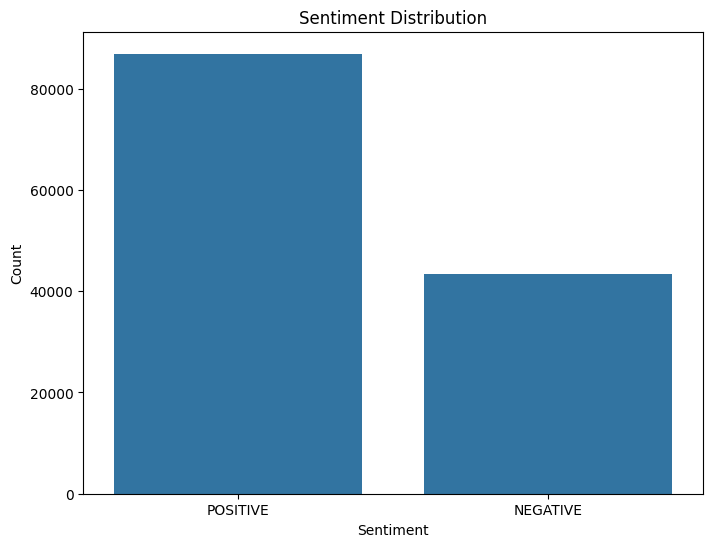

In [ ]:
sentiment_counts = new_train['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

plt.show()


In [ ]:
new_train['sentiment'].value_counts()

POSITIVE    86905
NEGATIVE    43301
Name: sentiment, dtype: int64

## Observation :
* ## Total 86905 Positive sentiments and 43301 Negative sentiments

### heatmap of missing values

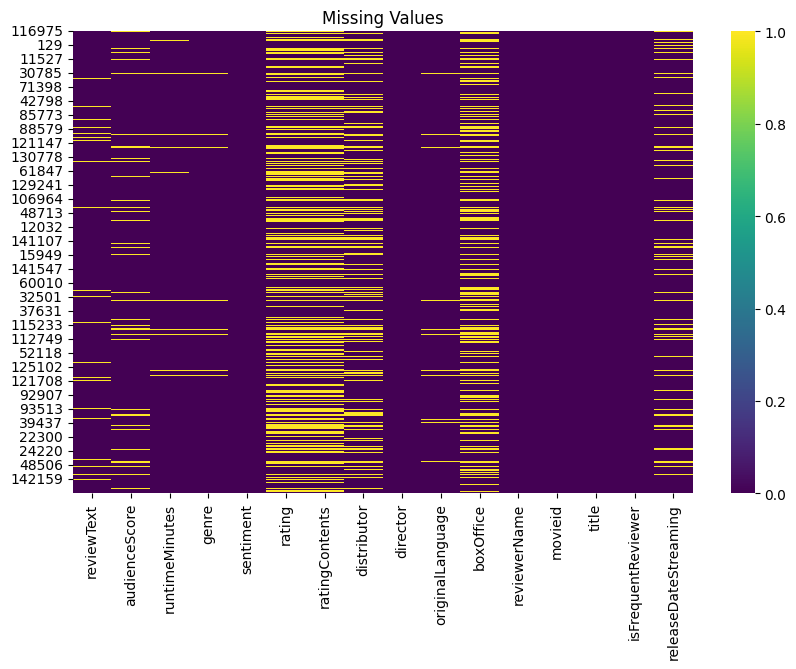

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(new_train.isna(), cmap = 'viridis')
plt.title("Missing Values")
plt.show()

### Observations :


* ## There are many columns with null values and a lot of preprocessing is needed in order to handle categorical data and numerical data.
* ## Director, reviewerName, movieid,title, isFrequentReviewer are the columns which do not content any missing value

### Bar plot for isFrequentReviewer

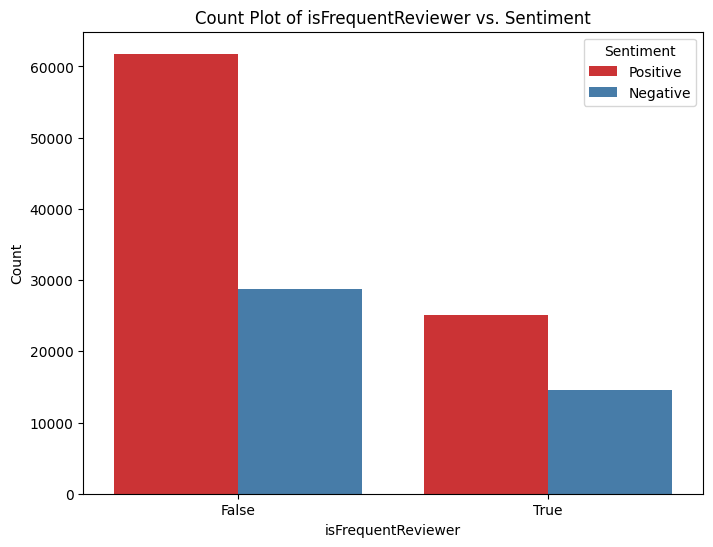

In [ ]:

# Bar plot for isFrequentReviewer


plt.figure(figsize=(8, 6))
sns.countplot(x='isFrequentReviewer', hue='sentiment', data=new_train, palette='Set1')
plt.title('Count Plot of isFrequentReviewer vs. Sentiment')
plt.xlabel('isFrequentReviewer')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right', labels=['Positive','Negative'])
plt.show()




### Distribution of Audience Score by Sentiment

<ipython-input-19-182c6a5d02ee>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='audienceScore', data=new_train.dropna(), palette='Set1')


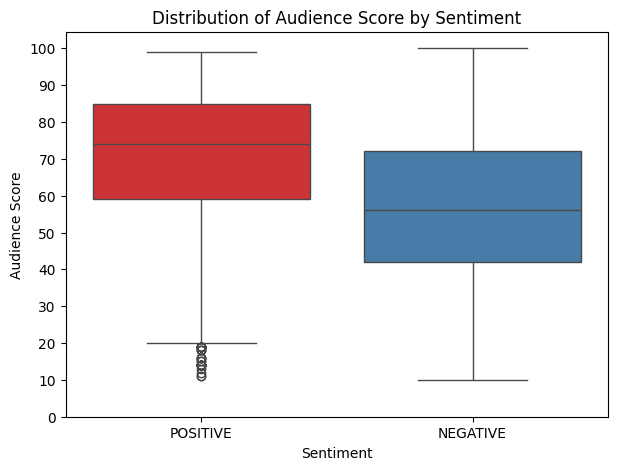

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='sentiment', y='audienceScore', data=new_train.dropna(), palette='Set1')
plt.title('Distribution of Audience Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.yticks(range(0, 101, 10))
plt.show()

### Observations

*      ## When Audience Score is below 40 or above 72 is then sentiment is 'POSITIVE'

Text(0.5, 1.0, 'KDE of Audience Score')

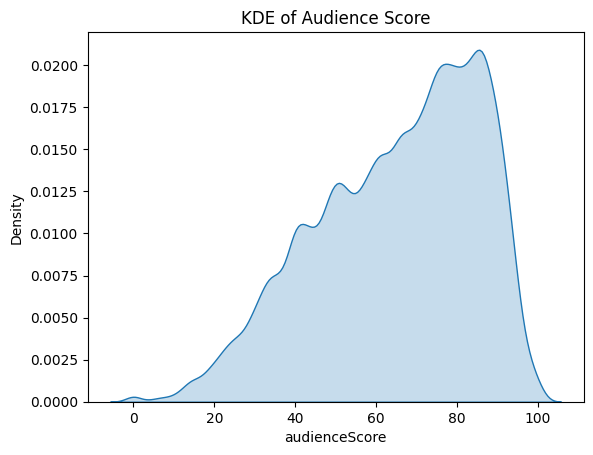

In [ ]:
sns.kdeplot(data = new_train['audienceScore'], fill =True)
plt.title("KDE of Audience Score")

# Data Preprocessing

## Data Preprocessing Conclusions

* ## As audienceScore is left tailed and have negative skewness so it should be imputed be median
* ## As runtimeMinutes have positive skewness so it should be imputed be mean
* ## For scaling Standard Scaler is used as it giving best result
* ## Categorical data is imputed with " "

In [ ]:
new_train['audienceScore'].skew()


-0.522208591933888

In [ ]:
new_train['runtimeMinutes'].skew()


1.8701846197915315

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy = 'median' , missing_values= np.nan)

new_train['audienceScore'] = imp.fit_transform(new_train[['audienceScore']])
new_test['audienceScore'] = imp.transform(new_test[['audienceScore']])
test_set['audienceScore'] = imp.transform(test_set[['audienceScore']])

<ipython-input-23-77629ffdfcb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['audienceScore'] = imp.transform(test_set[['audienceScore']])


In [ ]:
imp2 = SimpleImputer(strategy = 'mean' , missing_values= np.nan)
new_train['runtimeMinutes'] = imp.fit_transform(new_train[['runtimeMinutes']])
new_test['runtimeMinutes'] = imp.transform(new_test[['runtimeMinutes']])
test_set['runtimeMinutes'] = imp.transform(test_set[['runtimeMinutes']])

<ipython-input-24-15da8a13099a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['runtimeMinutes'] = imp.transform(test_set[['runtimeMinutes']])


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

scler = StandardScaler()

new_train['audienceScore'] = scler.fit_transform(new_train[['audienceScore']])
new_test['audienceScore'] = scler.transform(new_test[['audienceScore']])
test_set['audienceScore'] = scler.transform(test_set[['audienceScore']])


new_train['runtimeMinutes'] = scler.fit_transform(new_train[['runtimeMinutes']])
new_test['runtimeMinutes'] = scler.transform(new_test[['runtimeMinutes']])
test_set['runtimeMinutes'] = scler.transform(test_set[['runtimeMinutes']])

<ipython-input-25-793dfafec18d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['audienceScore'] = scler.transform(test_set[['audienceScore']])
<ipython-input-25-793dfafec18d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['runtimeMinutes'] = scler.transform(test_set[['runtimeMinutes']])


In [ ]:
new_train['boxOffice'] = new_train['boxOffice'].str.replace('$', "")
new_train['boxOffice'] = new_train['boxOffice'].str.replace('M', '000000')
new_train['boxOffice'] = new_train['boxOffice'].str.replace('K', '000')
new_train['boxOffice'] = new_train['boxOffice'].astype(float)

mm =new_train['boxOffice'].median()
new_train['boxOffice'] = new_train['boxOffice'].fillna(value = mm)


new_test['boxOffice'] = new_test['boxOffice'].str.replace('$', "")
new_test['boxOffice'] = new_test['boxOffice'].str.replace('M', '000000')
new_test['boxOffice'] = new_test['boxOffice'].str.replace('K', '000')
new_test['boxOffice'] = new_test['boxOffice'].astype(float)

nn =new_test['boxOffice'].median()
new_test['boxOffice'] = new_test['boxOffice'].fillna(value = nn)


test_set['boxOffice'] = test_set['boxOffice'].str.replace('$', "")
test_set['boxOffice'] = test_set['boxOffice'].str.replace('M', '000000')
test_set['boxOffice'] = test_set['boxOffice'].str.replace('K', '000')
test_set['boxOffice'] = test_set['boxOffice'].astype(float)

nn =test_set['boxOffice'].median()
test_set['boxOffice'] = test_set['boxOffice'].fillna(value = nn)



<ipython-input-26-91c7204093d8>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_train['boxOffice'] = new_train['boxOffice'].str.replace('$', "")
<ipython-input-26-91c7204093d8>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_test['boxOffice'] = new_test['boxOffice'].str.replace('$', "")
<ipython-input-26-91c7204093d8>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_set['boxOffice'] = test_set['boxOffice'].str.replace('$', "")
<ipython-input-26-91c7204093d8>:19: SettingWithCopyWarning: 
A value is trying

In [ ]:
new_train['releaseDateStreaming'].dtype

new_train['releaseDateStreaming'] = pd.to_datetime(new_train['releaseDateStreaming'])
new_test['releaseDateStreaming'] = pd.to_datetime(new_test['releaseDateStreaming'])
test_set['releaseDateStreaming'] = pd.to_datetime(test_set['releaseDateStreaming'])


new_train['day'] = new_train['releaseDateStreaming'].dt.day
new_train['month'] =  new_train['releaseDateStreaming'].dt.month
new_train['year'] =  new_train['releaseDateStreaming'].dt.year

new_test['day'] = new_test['releaseDateStreaming'].dt.day
new_test['month'] =  new_test['releaseDateStreaming'].dt.month
new_test['year'] =  new_test['releaseDateStreaming'].dt.year

test_set['day'] = test_set['releaseDateStreaming'].dt.day
test_set['month'] =  test_set['releaseDateStreaming'].dt.month
test_set['year'] =  test_set['releaseDateStreaming'].dt.year


new_train['day'] = imp.fit_transform(new_train[['day']])
new_test['day'] = imp.transform(new_test[['day']])
test_set['day'] = imp.transform(test_set[['day']])


new_train['month'] = imp.fit_transform(new_train[['month']])
new_test['month'] = imp.transform(new_test[['month']])
test_set['month'] = imp.transform(test_set[['month']])


new_train['year'] = imp.fit_transform(new_train[['year']])
new_test['year'] = imp.transform(new_test[['year']])
test_set['year'] = imp.transform(test_set[['year']])

<ipython-input-27-25eb61daa1af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['releaseDateStreaming'] = pd.to_datetime(test_set['releaseDateStreaming'])
<ipython-input-27-25eb61daa1af>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['day'] = test_set['releaseDateStreaming'].dt.day


In [ ]:
text_columns = ['reviewText', 'genre','rating', 'ratingContents' ,'director', 'originalLanguage','reviewerName','movieid','title','isFrequentReviewer']
for column in text_columns:
    new_train[column] = new_train[column].fillna(value='')
    new_test[column] = new_test[column].fillna(value='')
    test_set[column] = test_set[column].fillna(value='')

# Text Prerocessing

## Text Processing conclusions:

*          ## Two good vectorizers : 1. CountVectorizer  2. TfidfVectorizer
*          ## TfidfVectorizer perform better than CountVectorizer in most of the models
*          ## TfidfVectorizer is good with parameter as ngram_range = (1,2) for most of the models but, LogisticRegression is perform better with n_gram_range = (1,3)

In [ ]:
'''
vectorizer = TfidfVectorizer(ngram_range = (1,4))
X_train = vectorizer.fit_transform(df['reviewText'])
y_train = df['sentiment']
'''

"\nvectorizer = TfidfVectorizer(ngram_range = (1,4))\nX_train = vectorizer.fit_transform(df['reviewText'])\ny_train = df['sentiment']\n"

In [ ]:
"""
sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
text_matrix = vectorizer.fit_transform(df['reviewText'])
"""

"\nsklearn.feature_extraction.text import CountVectorizer\nvectorizer = CountVectorizer(lowercase=True, stop_words='english')\ntext_matrix = vectorizer.fit_transform(df['reviewText'])\n"

In [ ]:
test_set.isna().sum()

reviewText                  0
audienceScore               0
runtimeMinutes              0
genre                       0
rating                      0
ratingContents              0
distributor             15596
director                    0
originalLanguage            0
boxOffice                   0
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming     5974
day                         0
month                       0
year                        0
dtype: int64

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(stop_words = 'english',ngram_range = (1,2))

train_vector = vector.fit_transform(new_train['reviewText'] + ' ' + new_train['genre'] + ' ' + new_train['ratingContents'] + ' ' + new_train['director'] + ' ' + new_train['originalLanguage'] + ' ' + new_train['reviewerName']+ ' ' + new_train['movieid']+ ' ' + new_train['title']+ ' ' + new_train['isFrequentReviewer'].astype(str)+ ' ' + new_train['rating'].astype(str))
test_vector = vector.transform(new_test['reviewText'].astype(str) + ' ' + new_test['genre'].astype(str) + ' ' + new_test['ratingContents'].astype(str) + ' ' + new_test['director'].astype(str) + ' ' + new_test['originalLanguage'].astype(str) + ' ' + new_test['reviewerName'].astype(str)+ ' ' + new_test['movieid'].astype(str)+ ' ' + new_test['title'].astype(str)+ ' ' + new_test['isFrequentReviewer'].astype(str)+ ' ' + new_test['rating'].astype(str))
test_set_vector = vector.transform(test_set['reviewText'] + ' ' + test_set['genre'] + ' ' + test_set['ratingContents'] + ' ' + test_set['director'] + ' ' + test_set['originalLanguage'] + ' ' + test_set['reviewerName']+ ' ' + test_set['movieid']+ ' ' + test_set['title']+ ' ' + test_set['isFrequentReviewer'].astype(str)+ ' ' + test_set['rating'].astype(str))



In [ ]:
new_train.drop(columns= ['reviewText', 'sentiment', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage','reviewerName','movieid','title','boxOffice','isFrequentReviewer','releaseDateStreaming', 'day','month','year'], inplace=True)
new_test.drop(columns=['reviewText','sentiment', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage','reviewerName','movieid','title','boxOffice','isFrequentReviewer','releaseDateStreaming','day','month','year'], inplace=True)
test_set.drop(columns=['reviewText', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage','reviewerName','movieid','title','boxOffice','isFrequentReviewer','releaseDateStreaming','day','month','year'], inplace=True)


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   audienceScore   55315 non-null  float64
 1   runtimeMinutes  55315 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB


In [ ]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32552 entries, 20302 to 133274
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   audienceScore   32552 non-null  float64
 1   runtimeMinutes  32552 non-null  float64
dtypes: float64(2)
memory usage: 762.9 KB


In [ ]:
new_train.isna().sum()

audienceScore     0
runtimeMinutes    0
dtype: int64

In [ ]:

from scipy.sparse import hstack,csr_matrix
X = hstack([train_vector, csr_matrix(new_train)])
X_test = hstack([test_vector, csr_matrix(new_test)])
X_test_set = hstack([test_set_vector, csr_matrix(test_set)])

## Feature Selection

In [ ]:
# percentile = 40
# selector = SelectKPercentile(score_func=f_classif, percentile=percentile)
# X_selected = selector.fit_transform(X, y)



# Models and Classification Report

## Models Conclusion :
             
*                       ### best score is     0.83102       
*                       ### LinearSVC is best model so far, with hyperparameters C = 1 and max_iter = 400
*                       ### 2nd best model is Logistic regression with Hyperparameter Tunning
*                      ###  3rd best Model is RidgeClassifier
*                       ### Another Observation is training model with whole dataset without spliting increase the accuracy, for this case

## Model 1 : LogisticRegression

In [ ]:
# X = df['reviewText']
# y = df['sentiment']
# X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)

# """

# pipe = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('model', LogisticRegression())
# ])

# param_dist = {
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__use_idf': [True, False],
#     'model__C': uniform(0.1, 1.0),
#     'model__max_iter': [100, 200, 500],
# }

# random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1)
# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# """
# pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range = (1,2,), use_idf = True)),
#     ('model', LogisticRegression(C =  0.9555908857944696, max_iter= 200))
# ])

# pipe.fit(X_train, y_train)

# y_pred = pipe.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# pred = pipe.predict(X_test)

# print(classification_report(y_test,pred))
# print(confusion_matrix(y_test, pred))
# print(f1_score(pred, y_test,pos_label='POSITIVE'))

In [ ]:
# from scipy.stats import loguniform

# logreg = LogisticRegression(random_state = 42)

# param_dist = {
#     'C': loguniform(0.001, 1000),  # Regularization parameter
#     'max_iter': [100, 200, 300, 400, 500]
# }

# random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42)

# random_search.fit(X, y_trai)

# print("Best parameters:", random_search.best_params_)

# best_model = random_search.best_estimator_


# y_pred = best_model.predict(X_test)
# print("Classification Report:")
# print(classification_report(y_tes, y_pred))

# f1 = f1_score(y_tes, y_pred, pos_label="POSITIVE")
# print("F1 Score:", f1)

# pred_counts = pd.Series(y_pred).value_counts()
# print("Predicted Class Counts:")
# print(pred_counts)
# #  {'C': 18.77688470273464, 'max_iter': 500}

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C = 18.77, max_iter = 500, random_state = 42)
model.fit(X, y_trai)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))



              precision    recall  f1-score   support

    NEGATIVE       0.76      0.68      0.72     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
    macro avg       0.81      0.79      0.79     32552
    weighted avg    0.82      0.82      0.82     32552

    F1 Score : 0.8721844714269801

In [ ]:
conf_matrix  =confusion_matrix(y_tes, y_pred)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## Model 2 : LinearSVC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

linear_svc = LinearSVC(random_state = 42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(linear_svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, random_state = 42)

grid_search.fit(X_trai, y_trai)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_tes)
print("Classification Report:")
print(classification_report(y_tes, y_pred))
# F1 score on the test set
f1 = f1_score(y_tes, y_pred, pos_label="POSITIVE")
print("F1 Score:", f1)

pred_counts = pd.Series(y_pred).value_counts()
print("Predicted Class Counts:")
print(pred_counts)
# Best parameters: {'C': 1, 'max_iter': 400}


### Best parameters: {'C': 1, 'max_iter': 400}


In [ ]:
#best so far

from sklearn.svm import LinearSVC

model = LinearSVC(C = 1, max_iter = 400, random_state =42)
model.fit(X, y_trai)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))


              precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.72     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
    macro avg       0.81      0.79      0.79     32552
    weighted avg    0.82      0.82      0.82     32552

    F1 score  : 0.8724521584334668

In [ ]:
conf_matrix  =confusion_matrix(y_tes, y_pred)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## Model 3 :  RidgeClassifier


In [ ]:

# model13 = RidgeClassifier()

# param_grid = {
#     'alpha' : np.linspace(0.01, 10, 20),
#     'solver': ['auto', 'svd', ' cholesky', 'lsqr', ' sparse_cg', 'sag','saga']
# }

# grid_search = GridSearchCV(estimator = model13, param_grid = param_grid, cv =5)
# grid_search.fit(X_trai, y_trai)
# best_params = grid_search.best_params_


# #best_params: {'alpha': 3.096149524540197, 'solver': 'auto'}


# # best_model = RidgeClassifier(alpha = 3.096149524540197, solver = 'auto')
# # best_model.fit(X_trai, y_trai)
# # best_model.score(X_trai, y_trai)


# # score = 0.8725405509165947



In [ ]:

model = RidgeClassifier(alpha=  0.5357894736842106, solver= 'auto')
model.fit(X, y_trai)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))

                       precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.71     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
    macro avg       0.81      0.78      0.79     32552
    weighted avg    0.82      0.82      0.82     32552

    F1 score : 0.8721257677553825


In [ ]:
conf_matrix  =confusion_matrix(y_tes, y_pred)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

<!-- {'alpha': 0.5357894736842106, 'solver': 'auto'}
 -->

{'alpha': 2.2465170442181615, 'solver': 'sag'}

## Model 4 : SGDClassifier

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import SGDClassifier
# import numpy as np

# param_grid = {
#     'alpha': np.logspace(-6, 1, 8),
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'penalty': ['l2', 'l1', 'elasticnet']
# }

# model = SGDClassifier()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# grid_search.fit(X_trai, y_trai)

# best_params_grid = grid_search.best_params_

# print("Best parameters from grid search:", best_params_grid)

# best_model_grid = SGDClassifier(alpha=best_params_grid['alpha'], loss=best_params_grid['loss'], penalty=best_params_grid['penalty'])

# best_model_grid.fit(X_trai, y_trai)

# score_grid = best_model_grid.score(X_trai, y_trai)
# print("Best model's score:", score_grid)


In [ ]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(alpha=  0.1,eta0 = 0.5,learning_rate = 'adaptive', max_iter = 200,penalty = None, random_state = 0)
model.fit(X, y_trai)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))

In [ ]:
conf_matrix  =confusion_matrix(y_tes, y_pred)
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.68      0.71     10696
    POSITIVE       0.85      0.88      0.86     21856

    accuracy                           0.81     32552
    macro avg       0.79      0.78      0.79     32552
    weighted avg    0.81      0.81      0.81     32552

    f1 Score :0.8644589824869044

# Submission File

In [ ]:
pred = model.predict(X_test_set)

In [ ]:

submission = pd.DataFrame(columns = ['id', 'sentiment'])
submission['id'] = [i for i in range(len(pred))]
submission['sentiment'] = pred
submission.to_csv('submission.csv', index = False )

In [ ]:

pd.DataFrame(pred).value_counts()

# FINAL SUBMISSIONS SCORE : 0.83102
